# IMPORTS

In [1]:
import numpy as np
import pandas as pd
from gym import Env
from gym.spaces import Discrete, Box
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

perc_to_inv = 0.1

class TradingEnv(Env):
    def __init__(self, data, initial_balance=10000):
        # Dataset y parámetros iniciales
        self.data = data
        self.initial_balance = initial_balance
        
        # Espacios de acción: 0 = Mantener, 1 = Comprar, 2 = Vender
        self.action_space = Discrete(3)
        
        # Espacios de observación: Estado del mercado (excluyendo columnas irrelevantes)
        self.observation_space = Box(
            low=-np.inf, high=np.inf, shape=(data.shape[1] - 0,), dtype=np.float32
        )
        
        # Variables internas
        self.reset()

    def seed(self, seed=None):
        np.random.seed(seed)

    def reset(self):
        self.balance = self.initial_balance
        self.position = 0  # Número de acciones compradas
        self.current_step = 0
        self.done = False
        
        return self._get_observation()

    def step(self, action):
        # Guardar estado inicial
        prev_balance = self.balance
        prev_position_value = self.position * self.data['close'].iloc[self.current_step]
        prev_portfolio_value = prev_balance + prev_position_value

        # Ejecutar acción
        current_price = self.data['close'].iloc[self.current_step]
        if action == 1:  # Comprar
            amount_to_buy = min(self.balance, perc_to_inv * self.balance)  
            self.position += amount_to_buy / current_price
            self.balance -= amount_to_buy
        elif action == 2:  # Vender
            amount_to_sell = min(self.position, perc_to_inv * self.position)
            self.balance += amount_to_sell * current_price
            self.position -= amount_to_sell

        # Calcular recompensa
        position_value = self.position * current_price
        portfolio_value = self.balance + position_value
        reward = portfolio_value - prev_portfolio_value

        # Actualizar estado
        self.current_step += 1
        if self.current_step >= len(self.data) - 1:
            self.done = True

        return self._get_observation(), reward, self.done, {}

    def _get_observation(self):
        # Retorna el estado actual (excluye columnas no relevantes)
        obs = self.data.iloc[self.current_step]
        # obs = (obs - obs.mean()) / (obs.std() + 1e-8)
        return obs.values.astype(np.float32)




In [ ]:
from tft_helper import load_file

# Dividir los datos en entrenamiento y prueba
data = load_file(file_name='BTC', path="./", ftype="csv").drop(columns=['Date']) #,'month','day_of_year','weekday','is_holiday'])

# Dividir datos en entrenamiento y prueba
split_index = int(len(data) * 0.8)
train_data = data[:split_index]
test_data = data[split_index:]


c:\Users\nicov\anaconda3\envs\tradingBot\lib\site-packages\pytorch_forecasting\models\base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
train_data

,Date,close,open,max,min,var,exog_Nasdaq,exog_IBEX35,exog_EUStoxx50,exog_DowJones,...,bullish_rsi,bearish_rsi,bullish_bollinger,bearish_bollinger,bullish_macd,bearish_macd,bullish_atr,bearish_atr,bullish_trend,bearish_trend
0,2016-01-01,434.0,430.0,438.0,425.9,0.94,4497.86,9313.2,3164.76,17148.94,...,0,0,0,0,0,0,0,0,0,0
1,2016-01-02,433.7,434.0,437.4,430.7,-0.06,4497.86,9313.2,3164.76,17148.94,...,0,0,0,0,0,1,0,0,0,0
2,2016-01-03,430.7,433.7,434.1,423.1,-0.70,4497.86,9313.2,3164.76,17148.94,...,0,0,0,0,0,1,0,0,0,0
3,2016-01-04,433.3,430.7,435.3,428.6,0.61,4497.86,9313.2,3164.76,17148.94,...,0,0,0,0,0,1,0,0,0,0
4,2016-01-05,431.2,433.3,435.3,428.9,-0.49,4484.18,9335.2,3178.01,17158.66,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2501,2022-11-06,20916.3,21298.7,21360.4,20901.0,-1.81,10857.03,7942.7,3688.33,32403.22,...,0,0,0,0,1,0,1,0,0,0
2502,2022-11-07,20589.0,20916.3,21055.4,20410.5,-1.56,10977.00,7962.3,3708.80,32827.00,...,0,0,0,0,1,0,1,0,0,0
2503,2022-11-08,18527.4,20589.0,20667.5,17260.0,-10.01,11059.50,7998.9,3739.28,33160.83,...,0,0,1,0,0,1,1,0,0,0
2504,2022-11-09,15886.9,18538.9,18583.8,15603.3,-14.25,10797.55,8040.4,3728.03,32513.94,...,1,0,1,0,0,1,1,0,1,0


### rollout/
- **ep_len_mean**: Longitud promedio de los episodios. Un episodio termina cuando se alcanza el final del conjunto de datos o un criterio definido en el entorno. Aquí, se muestra 1.71e+03 (aproximadamente 1710 pasos), lo que indica que los episodios son largos.
- **ep_rew_mean**: Recompensa promedio por episodio. Un valor de 0 aquí indica que las recompensas proporcionadas no están incentivando al modelo de manera efectiva.

### time/
- **fps**: Pasos por segundo procesados durante el entrenamiento.
- **iterations**: Número de iteraciones completadas.
- **time_elapsed**: Tiempo total transcurrido durante el entrenamiento.
- **total_timesteps**: Número total de pasos de entrenamiento procesados.

### train/
- **approx_kl**: Aproximación al KL-divergence. Un valor bajo indica que las políticas no están cambiando demasiado rápido, lo cual es deseable.
- **clip_fraction**: Fracción de las acciones que excedieron el rango permitido por la política de clipping. Un valor bajo es ideal.
- **entropy_loss**: Representa la incertidumbre de las acciones. Valores más altos indican más exploración, mientras que valores bajos indican más confianza en las políticas aprendidas.
- **explained_variance**: Qué tan bien la red de valor predice las recompensas futuras. Un valor cercano a 1 indica una buena predicción, mientras que valores cercanos a 0 indican problemas.
- **loss**: La pérdida total que se optimiza. Puede incluir la pérdida de la política y el valor.
- **policy_gradient_loss**: Pérdida relacionada con las acciones tomadas por la política.


In [4]:

# Crear entorno de entrenamiento
env = make_vec_env(lambda: TradingEnv(train_data), n_envs=1)

# Configurar y entrenar el modelo
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

# Guardar el modelo
# model.save("trading_bot_model")


ValueError: could not convert string to float: '2016-01-01'

In [ ]:
# Evaluar en el conjunto de prueba
eval_env = TradingEnv(test_data)
eval_obs = eval_env.reset()
total_reward = 0

while True:
    action, _states = model.predict(eval_obs)
    eval_obs, reward, done, _ = eval_env.step(action)
    total_reward += reward
    if done:
        break

print("Recompensa total en el conjunto de prueba:", total_reward)

Recompensa total en el conjunto de prueba: -2.546585164964199e-11


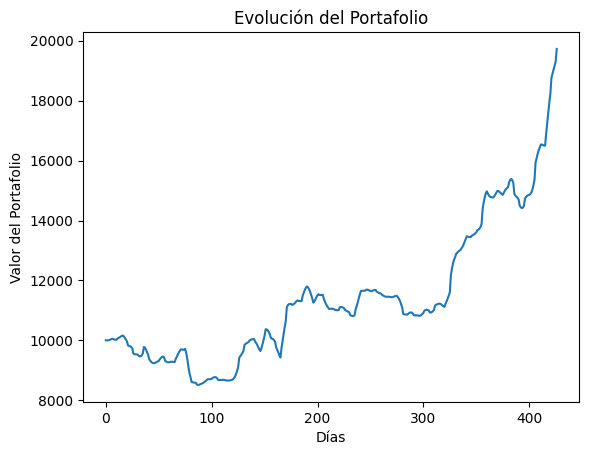

In [ ]:
import matplotlib.pyplot as plt

portfolio_values = []
eval_env = TradingEnv(test_data)
eval_obs = eval_env.reset()

while True:
    action, _states = model.predict(eval_obs)
    eval_obs, reward, done, _ = eval_env.step(action)
    portfolio_values.append(eval_env.balance + eval_env.position * eval_env.data['close'].iloc[eval_env.current_step])
    if done:
        break

plt.plot(portfolio_values)
plt.title('Evolución del Portafolio')
plt.xlabel('Días')
plt.ylabel('Valor del Portafolio')
plt.show()


In [ ]:
# Evaluar rentabilidad acumulada
eval_env = TradingEnv(test_data)
eval_obs = eval_env.reset()
portfolio_values = []

while True:
    action, _states = model.predict(eval_obs)
    eval_obs, reward, done, _ = eval_env.step(action)
    portfolio_values.append(eval_env.balance + eval_env.position * eval_env.data['close'].iloc[eval_env.current_step])
    if done:
        break

initial_value = portfolio_values[0]
final_value = portfolio_values[-1]
cumulative_return = (final_value / initial_value) - 1

print("Rentabilidad acumulada:", cumulative_return)

Rentabilidad acumulada: 0.8546506805150849


In [ ]:
# Ratio de Sharpe: Relación entre la rentabilidad y el riesgo asumido. Valores superiores a 1 son aceptables; valores superiores a 2 son excelentes.
import numpy as np

returns = np.diff(portfolio_values) / portfolio_values[:-1]  # Retornos diarios
sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)  # 252 días de mercado al año
print("Sharpe Ratio:", sharpe_ratio)

# Drawdown máximo: La mayor caída desde un pico histórico del portafolio. Evalúa el riesgo.
drawdown = np.max(np.maximum.accumulate(portfolio_values) - portfolio_values)
max_drawdown = drawdown / np.maximum.accumulate(portfolio_values).max()
print("Máximo Drawdown:", max_drawdown)


Sharpe Ratio: 2.842997085770828
Máximo Drawdown: 0.09107242856466376


In [ ]:
import numpy as np
import pandas as pd
from gym import Env
from gym.spaces import Discrete, Box
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
import matplotlib.pyplot as plt

class TradingEnv(Env):
    def __init__(self, data, initial_balance=10000):
        # Dataset y parámetros iniciales
        self.data = data
        self.initial_balance = initial_balance
        
        # Espacios de acción: 0 = Mantener, 1 = Comprar, 2 = Vender
        self.action_space = Discrete(3)
        
        # Espacios de observación: Estado del mercado (excluyendo columnas irrelevantes)
        self.observation_space = Box(
            low=-np.inf, high=np.inf, shape=(data.shape[1] - 0,), dtype=np.float32
        )
        
        # Variables internas
        self.reset()

    def seed(self, seed=None):
        np.random.seed(seed)

    def reset(self):
        self.balance = self.initial_balance
        self.position = 0  # Número de acciones compradas
        self.current_step = 0
        self.done = False
        
        return self._get_observation()

    def step(self, action):
        # Guardar estado inicial
        prev_balance = self.balance
        prev_position_value = self.position * self.data['close'].iloc[self.current_step]
        prev_portfolio_value = prev_balance + prev_position_value

        # Ejecutar acción
        current_price = self.data['close'].iloc[self.current_step]
        if action == 1:  # Comprar
            amount_to_buy = min(self.balance, 0.1 * self.balance)  # Máximo 10%
            self.position += amount_to_buy / current_price
            self.balance -= amount_to_buy
        elif action == 2:  # Vender
            amount_to_sell = min(self.position, 0.1 * self.position)  # Máximo 10%
            self.balance += amount_to_sell * current_price
            self.position -= amount_to_sell

        # Calcular recompensa
        position_value = self.position * current_price
        portfolio_value = self.balance + position_value
        reward = portfolio_value - prev_portfolio_value

        # Actualizar estado
        self.current_step += 1
        if self.current_step >= len(self.data) - 1:
            self.done = True

        return self._get_observation(), reward, self.done, {}

    def _get_observation(self):
        # Retorna el estado actual (excluye columnas no relevantes)
        obs = self.data.iloc[self.current_step].drop(['Date', 'month', 'day_of_year', 'weekday', 'is_holiday'])
        return obs.values.astype(np.float32)  # Convertir a float32 para compatibilidad

# Cargar datos
from tft_helper import load_file

# Dividir los datos en entrenamiento y prueba
data = load_file(file_name='BTC', path="./", ftype="csv").drop(columns=['Date','month','day_of_year','weekday','is_holiday'])

# Dividir datos en entrenamiento y prueba
split_index = int(len(data) * 0.8)
train_data = data[:split_index]
test_data = data[split_index:]

# Validación cruzada
n_splits = 3  # Número de divisiones para validación cruzada
split_size = len(data) // n_splits

results = []

for i in range(n_splits):
    # Dividir en entrenamiento, validación y prueba
    train_data = data[:i * split_size]
    validation_data = data[i * split_size:(i + 1) * split_size]
    test_data = data[(i + 1) * split_size:]

    # Crear y entrenar el modelo
    env = make_vec_env(lambda: TradingEnv(train_data), n_envs=1)
    model = PPO("MlpPolicy", env, verbose=1)
    model.learn(total_timesteps=10000)

    # Evaluar en el conjunto de validación
    eval_env = TradingEnv(validation_data)
    eval_obs = eval_env.reset()
    portfolio_values = []

    while True:
        action, _states = model.predict(eval_obs)
        eval_obs, reward, done, _ = eval_env.step(action)
        portfolio_values.append(eval_env.balance + eval_env.position * eval_env.data['close'].iloc[eval_env.current_step])
        if done:
            break

    # Calcular métricas de rendimiento
    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252) if returns.std() != 0 else 0
    drawdown = np.max(np.maximum.accumulate(portfolio_values) - portfolio_values)
    max_drawdown = drawdown / np.maximum.accumulate(portfolio_values).max()

    results.append({
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'final_portfolio_value': portfolio_values[-1]
    })

# Imprimir resultados
for i, result in enumerate(results):
    print(f"Fold {i + 1}:")
    print(f"  Sharpe Ratio: {result['sharpe_ratio']:.2f}")
    print(f"  Máximo Drawdown: {result['max_drawdown']:.2%}")
    print(f"  Valor Final del Portafolio: {result['final_portfolio_value']:.2f}\n")


IndexError: single positional indexer is out-of-bounds